### КЛАССИФИКАЦИЯ ИЗОБРАЖЕНИЙ НА ОСНОВЕ ТЕКСТА ДОКУМЕНТА И САМОГО ИЗОБРАЖЕНИЯ

Данильченко Вадим

Документ как может содержать текст, так и нет, соответственно если текста нет, он считается "unknown", далее в генераторах подгружаем изображения с диска из заранее подготовленного батча определенного размера (то есть не держим все изображения в памяти, а только нужные)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm, os, joblib, math, re, random
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, Sequence
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image
from pdf2image import convert_from_path
from pytesseract import image_to_string
from collections import Counter

In [3]:
# создадим список модель-класс
path = 'F:\documents'
file2classname = []
for subpath in tqdm.tqdm(os.listdir(path)):
    if subpath!='result':
        for filename in os.listdir(os.path.join(path, subpath)):
            if any([_ in filename.lower() for _ in ['.pdf', '.jpeg', '.jpg', '.bmp', '.png']]):
                file2classname.append([subpath, filename])

100%|████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 1295.04it/s]


In [4]:
file2class = pd.DataFrame(file2classname)
file2class.columns = ['category', 'filename']
file2class['target'] = file2class['category'].astype('category').cat.codes
print(file2class.shape)

(3351, 3)


In [4]:
# формируем обучающую и проверочную выборки
vaidation_split = 0.2
batch = 5

labels = to_categorical(np.asarray(file2class['target'].tolist()))
im_list = file2class[['category', 'filename']].apply(lambda x: os.path.join(path, x[0], x[1]), axis=1).tolist()



x_train, x_test, y_train, y_test = train_test_split(im_list, 
                                                    labels, 
                                                    test_size=vaidation_split, 
                                                    random_state=777,
                                                    shuffle=True)

In [7]:
# извлечем текст для формирования токенайзера
def extract_text(im):
    try:
        # распознаем документ
        if any(i in im.lower() for i in ['jpeg', 'jpg', 'bmp', 'png']):
            img = Image.open(im)
        elif 'pdf' in im.lower():
            img = convert_from_path(im, 
                                    poppler_path=r'C:\poppler-0.90.1\bin', 
                                    single_file=True)

        # извлечем текст
        txt = image_to_string(img, config='-l eng+rus --oem 3 --psm 3')
        txt = re.sub('[\W\s_]{1,}', ' ', txt.lower())
    except:
        txt = 'unknown'
    print('{:*^100}'.format(im+': '+('True' if txt!='unknown' else 'False')))
    return txt



texts = []
for i in tqdm.tqdm(range(file2class.shape[0])):
    texts.append(extract_text(os.path.join(path, file2class['category'].iloc[i], file2class['filename'].iloc[i])))

file2class['text'] = texts

maxlen = 500 

# создадим токенизатор
tokenizer = Tokenizer(num_words=maxlen, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts)
items = list(tokenizer.word_index.items())
items[:2]
sequences = tokenizer.texts_to_sequences(texts)
sequences[:2]

# # преобразуем в one hot encoding формат
# xTrainRez01 = tokenizer.sequences_to_matrix(sequences) 
# print(xTrainRez01.shape)                                      
# print(xTrainRez01[0][0:100]) 

[[23671,
  86,
  23671,
  23671,
  23671,
  8,
  23671,
  23671,
  23671,
  23671,
  23671,
  2,
  23671,
  39,
  23671,
  23671,
  8,
  23671,
  57,
  105,
  67,
  23671,
  6,
  57,
  105,
  67,
  7,
  11,
  23671,
  274,
  23671,
  81,
  23671,
  23671,
  20,
  23671,
  23671,
  94,
  27,
  118,
  29,
  100,
  88,
  12,
  22,
  2,
  23671,
  23671,
  23671,
  13,
  23671,
  23671,
  214,
  5,
  275,
  23671,
  85,
  23671,
  23671,
  23671,
  23671,
  6,
  23671,
  23671,
  23671,
  23671,
  32,
  23671,
  42,
  23671,
  23671,
  23671,
  23671,
  60,
  23671,
  23671,
  214,
  85,
  23671,
  23671,
  282,
  406,
  23671,
  23671,
  23671,
  23671,
  23671,
  23671,
  23671,
  2,
  23671,
  23671,
  11,
  23671,
  23671,
  23671,
  2,
  23671,
  8,
  23671,
  23671,
  23671,
  23671,
  6,
  2,
  23671,
  42,
  23671,
  23671,
  23671,
  59,
  23671,
  36,
  23671,
  23671,
  2,
  23671,
  23671,
  23671,
  23671,
  45,
  23671,
  2,
  23671,
  23671,
  23671,
  23671,
  8,
  23671,
 

In [8]:
# генератор обучающей и тренирововчной выборки для текста и изображения



img_width = 120 #Ширина изображения
img_height = 360 #Высота изображения
classes = 30


class DataGenerator(Sequence):
    """
    Keras Sequence object to train a model on larger-than-memory data.
    """
    def __init__(self, data_path, batch_size, im_list, labels, data_type, mode='train'):
        self.bsz = batch_size
        self.labels = labels
        self.im_list = im_list
        self.mode = mode
        self.data_type = data_type
        self.batch_x = 0
        self.batch_y = 0
        self.batch_x_ros = 0
        self.batch_y_ros = 0

    def __len__(self):
        return int(math.ceil(len(self.labels) / float(self.bsz)))

    # загружаем изображение по входящей ссылке на файл
    def load_image(self, im):
        #         print(im)
        # распознаем документ
        if any(i in im.lower() for i in ['jpeg', 'jpg', 'bmp', 'png']):
            img = Image.open(im)
        elif 'pdf' in im.lower():
            img = convert_from_path(im, 
                                    poppler_path=r'C:\poppler-0.90.1\bin', 
                                    single_file=True)[0]
        else:
            raise Exception(f'unknown file type: {im}')
        return img    
    
    # извлекаем данные с изображения
    def extract_image(self, img):

        # проверим на цветовую гамму, если не RGB, то конвертируем в RGB
        if img.mode!='RGB':
            img = img.convert('RGB')

        return img_to_array(img.resize((img_width, img_height), 3)) / 255.
    
    # извлечем текст
    def extract_text(self, im):
#         корректый код при чтении из файла
        try:
            txt = image_to_string(img, config='-l eng+rus --oem 3 --psm 3')
            txt = re.sub('[\W\s_]{1,}', ' ', txt.lower())
        except:
            txt = 'unknown'
        print('{:*^100}'.format(filename+': '+('True' if txt!='' else 'False')))
        
        if not txt:
            txt = 'unknown'
#         print(txt)
        return txt

    # векторизуем текст в one hot encoding длины maxlen
    def vectorize_text(self, txt):
        sequence = tokenizer.texts_to_sequences([txt])
        vector = np.asarray(tokenizer.sequences_to_matrix(sequence)[0])
#         print(vector.shape)
        return vector
        

    def oversampling(self):
        cntr = Counter(np.argmax(self.batch_y, axis=1))
        max_cnt = max(cntr.values())
#         print(max_cnt)

        y_list = np.argmax(self.batch_y, axis=1)
        y_dict_new = dict(cntr)
        x_batch_new = []
        y_list_new = []
        for i in range(len(y_list)):
            if y_dict_new[y_list[i]]<max_cnt:
                for _ in range(2):
                    x_batch_new.append(self.batch_x[i])
                    y_list_new.append(y_list[i])
                    y_dict_new[y_list[i]]+=1
            else:
                x_batch_new.append(self.batch_x[i])
                y_list_new.append(y_list[i])
                y_dict_new[y_list[i]]+=1
        return np.asarray(x_batch_new), to_categorical(np.asarray(y_list_new), num_classes=classes)
    
    
#     перемешиваем все элементы, когда находимся в режиме обучения
    def on_epoch_end(self):
        self.indexes = range(len(self.labels))
        if self.mode == 'train':
            self.indexes = random.sample(self.indexes, k=len(self.indexes))

    # формируем батч из меток класса, который хранится в памяти
    def get_batch_labels(self, idx):
        return self.labels[idx * self.bsz: (idx + 1) * self.bsz]
    
    # формируем батч фичей, которые будут извлечены из изображений на диске
    def get_batch_features(self, idx):
        if self.data_type=='image':
            return np.array([self.extract_image(self.load_image(im)) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])
        elif self.data_type=='text':
#             раскомментить при извлечении текста с нуля            
            return np.array([self.vectorize_text(self.extract_text(self.load_image(im))) for im in self.im_list[idx * self.bsz: (1 + idx) * self.bsz]])


    def __getitem__(self, idx):
        self.batch_x = self.get_batch_features(idx)
        self.batch_y =self.get_batch_labels(idx)
#         print(self.batch_x.shape)
#         print(self.batch_y.shape)
#         if self.data_type=='image':
#             self.batch_x = self.batch_x.reshape((self.bsz, img_width*img_height*3))

#  oversampling
#         self.batch_x_ros, self.batch_y_ros = ros.fit_resample(self.batch_x, self.batch_y)
#         self.batch_y_ros = to_categorical(self.batch_y_ros,30)
        self.batch_x_ros, self.batch_y_ros = self.oversampling()
#         print(self.batch_x_ros.shape, self.batch_x.shape)
#         print(self.batch_y_ros.shape, self.batch_y.shape)

        return self.batch_x_ros, self.batch_y_ros
#         return self.batch_x, self.batch_y

In [9]:
# формируем обучающую и проверочную выборки
validation_split = 0.1
batch = 64

labels = to_categorical(np.asarray(file2class['target'].tolist()))
im_list = file2class[['category', 'filename']].apply(lambda x: os.path.join(path, x[0], x[1]), axis=1).tolist()



x_train, x_test, y_train, y_test = train_test_split(im_list, 
                                                    labels, 
                                                    test_size=validation_split, 
                                                    random_state=777,
                                                    shuffle=True)


# image generator
train_gen_image = DataGenerator(path, batch, x_train, y_train, 'image')
test_gen_image = DataGenerator(path, batch, x_test, y_test, 'image')
# text generator
train_gen_text = DataGenerator(path, batch, x_train, y_train, 'text')
test_gen_text = DataGenerator(path, batch, x_test, y_test, 'text')

In [11]:
# генератор для подачи одновременно и генератора изображений и генератора текста на вход
class MultipleInputGenerator(Sequence):
    """Wrapper of 2 ImageDataGenerator"""

    def __init__(self, data_path, batch_size, im_list, labels, train_test_type):
        
        if train_test_type=='train':
            self.gen_image = DataGenerator(path, batch, x_train, y_train, 'image')
            self.gen_text = DataGenerator(path, batch, x_train, y_train, 'text')
        elif train_test_type=='test':
            self.gen_image = DataGenerator(path, batch, x_test, y_test, 'image')
            self.gen_text = DataGenerator(path, batch, x_test, y_test, 'text')

    def __len__(self):
        """It is mandatory to implement it on Keras Sequence"""
        return self.gen_image.__len__()

    def __getitem__(self, index):
        """Getting items from the 2 generators and packing them"""
        X1_batch, Y_batch = self.gen_image.__getitem__(index)
        X2_batch, Y_batch = self.gen_text.__getitem__(index)

        X_batch = [X1_batch, X2_batch]

        return X_batch, Y_batch

In [12]:
# модель
inp_img = Input(shape=(img_width, img_height, 3), name='int_image')
x = BatchNormalization()(inp_img)
x = Conv2D(32, (3,3), padding='same', activation='relu', name='img_conv2d_1')(x)
x = Conv2D(64, (3,3), padding='same', activation='relu', name='img_conv2d_2')(x)
x = Dropout(0.2)(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(128, (3,3), padding='same', activation='relu', name='img_conv2d_3')(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Flatten(name='flaten_img')(x)
# inp_img = Input(shape=(img_width*img_height*3,), name='int_image')
x = Dense(6144, activation='relu', name='img_dense_1')(x)
x = Dropout(0.2)(x)
x = Dense(2048, activation='relu', name='img_dense_2')(x)
x = Dense(1024, activation='relu', name='img_dense_3')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', name='img_dense_4')(x)
x = Flatten()(x)

inp_text = Input(shape=(maxlen), name='int_text')
# x2 = BatchNormalization()(inp_text)
x2 = Dense(500, activation='relu', name='text_dense_1')(inp_text)
x2 = Dense(200, activation='relu', name='text_dense_2')(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(128, activation='relu', name='text_dense_3')(x2)
x2 = Flatten()(x2)

x_out = Concatenate(name='concat')([x,x2])
x_out = Flatten(name='flaten_concat')(x_out)
x_out = Dense(200, activation='relu', name='concat_dense_1')(x_out)
x_out = Dropout(0.3)(x_out)
x_out = Dense(100, activation='relu', name='concat_dense_2')(x_out)
x_out = Dropout(0.3)(x_out)
x_out = Dense(50, activation='relu', name='concat_dense_3')(x_out)

output = Dense(classes, activation='softmax', name='output')(x_out)
model = Model([inp_img, inp_text], output)

#Компилируем сеть
model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(lr=1e-3), 
              metrics=["accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
int_image (InputLayer)          [(None, 120, 360, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 120, 360, 3)  12          int_image[0][0]                  
__________________________________________________________________________________________________
img_conv2d_1 (Conv2D)           (None, 120, 360, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
img_conv2d_2 (Conv2D)           (None, 120, 360, 64) 18496       img_conv2d_1[0][0]               
______________________________________________________________________________________________

In [13]:
%%time
model.fit_generator(MultipleInputGenerator(path, batch, x_train, y_train, 'train'), 
                    epochs=15, 
                    validation_data = MultipleInputGenerator(path, batch, x_test, y_test, 'test'),
                    verbose=1, 
                    use_multiprocessing=False, 
                    workers=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
48/48 [==============================] - 570s 12s/step - loss: 3.4080 - accuracy: 0.1276 - val_loss: 2.6396 - val_accuracy: 0.3914
Epoch 2/15
48/48 [==============================] - 510s 11s/step - loss: 2.0674 - accuracy: 0.3882 - val_loss: 1.6183 - val_accuracy: 0.5479
Epoch 3/15
48/48 [==============================] - 498s 10s/step - loss: 1.4161 - accuracy: 0.5909 - val_loss: 1.2766 - val_accuracy: 0.6712
Epoch 4/15
48/48 [==============================] - 490s 10s/step - loss: 1.0401 - accuracy: 0.7073 - val_loss: 1.1664 - val_accuracy: 0.6888
Epoch 5/15
48/48 [==============================] - 524s 11s/step - loss: 0.8370 - accuracy: 0.7628 - val_loss: 1.0756 - val_accuracy: 0.7104
Epoch 6/15
48/48 [==============================] - 507s 11s/step - loss: 0.6802 - accuracy: 0.8098 - val_loss: 1.0454 - val_accuracy: 0.7436
Epoch 7/15
48/48 [==============================] - 525s 11s/step - loss

In [14]:
# (128, 30)
# (128, 500)
# (128, 30)
# (128, 360, 120, 3)

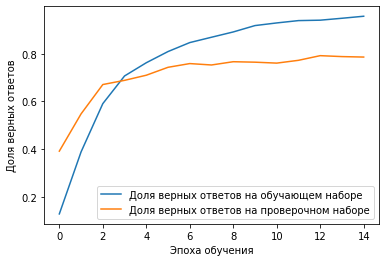

In [15]:
#Оображаем график точности обучения
plt.plot(model.history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(model.history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# сохраним модель в json

In [22]:
# serialize model to JSON
model_json = model.to_json()
with open(r'F:\documents\result\docs_classification_model.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(r'F:\documents\result\json_model_weights.hdf5')
print("Saved model to disk")

Saved model to disk


In [26]:
# load json and create model
json_file = open(r'F:\documents\result\docs_classification_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(r'F:\documents\result\json_model_weights.hdf5')
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# evaluate loaded model on test data
loaded_model.compile(loss="categorical_crossentropy", 
                      optimizer=Adam(lr=1e-3), 
                      metrics=["accuracy"])
score = loaded_model.evaluate([get_batch_features(x_test, 'image'), get_batch_features(x_test, 'text')], y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

# accuracy: 78.87%

# predict

In [17]:
# загружаем изображение по входящей ссылке на файл
def load_image(im):
    #         print(im)
    # распознаем документ
    if any(i in im.lower() for i in ['jpeg', 'jpg', 'bmp', 'png']):
        img = Image.open(im)
    elif 'pdf' in im.lower():
        img = convert_from_path(im, 
                                poppler_path=r'C:\poppler-0.90.1\bin', 
                                single_file=True)[0]
    else:
        raise Exception(f'unknown file type: {im}')
    return img    

# извлекаем данные с изображения
def extract_image(img):

    # проверим на цветовую гамму, если не RGB, то конвертируем в RGB
    if img.mode!='RGB':
        img = img.convert('RGB')

    return img_to_array(img.resize((img_width, img_height), 3)) / 255.

# извлечем текст
def extract_text(img, filename):
#     корректый код при чтении из файла
    try:
        txt = image_to_string(img, config='-l eng+rus --oem 3 --psm 3')
        txt = re.sub('[\W\s_]{1,}', ' ', txt.lower())
    except:
        txt = 'unknown'
    print('{:*^100}'.format(filename +': '+('True' if txt!='' else 'False')))

    if len(txt)==0:
        txt = 'unknown'
#         print(txt)
    return txt

# векторизуем текст в one hot encoding длины maxlen
def vectorize_text(txt):
    sequence = tokenizer.texts_to_sequences([txt])
    vector = np.asarray(tokenizer.sequences_to_matrix(sequence)[0])
#         print(vector.shape)
    return vector


def get_batch_features(im_list, data_type):
    if data_type=='image':
        return np.array([extract_image(load_image(im)) for im in im_list])
    elif data_type=='text':
    #             раскомментить при извлечении текста с нуля            
        return np.array([vectorize_text(extract_text(load_image(im), im)) for im in im_list])
    #         return np.array([vectorize_text(extract_text(im)) for im in im_list])

In [ ]:
predictions = model.predict([get_batch_features(x_test, 'image'), get_batch_features(x_test, 'text')])

In [21]:
# after oversampling
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.79      0.92      0.85        12
           3       1.00      0.50      0.67         6
           4       1.00      0.33      0.50         3
           5       0.67      1.00      0.80         2
           6       1.00      0.50      0.67         4
           7       1.00      1.00      1.00         1
          10       0.00      0.00      0.00         1
          11       1.00      0.83      0.91         6
          13       0.83      0.81      0.82        31
          14       0.84      0.90      0.87        29
          15       1.00      1.00      1.00         2
          16       0.86      0.73      0.79        26
          17       0.83      1.00      0.91         5
          18       1.00      0.50      0.67         2
          19       1.00      0.80      0.89         5
          20       0.00      0.00      0.00         1
          21       0.77    

In [43]:
# before oversampling
print(classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           2       0.62      0.83      0.71        12
           3       0.60      0.50      0.55         6
           4       0.00      0.00      0.00         3
           5       0.40      1.00      0.57         2
           6       0.57      1.00      0.73         4
           7       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         1
          11       0.67      0.67      0.67         6
          13       1.00      0.87      0.93        31
          14       0.96      0.90      0.93        29
          15       1.00      1.00      1.00         2
          16       0.68      0.73      0.70        26
          17       0.71      1.00      0.83         5
          18       0.50      0.50      0.50         2
          19       0.75      0.60      0.67         5
          20       0.00      0.00      0.00         1
          21       0.90    